In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cmdstanpy import CmdStanModel
import pandas as pd
import json
import pickle
import os

# Load data

## Behavioural data


In [15]:

df_raw = pd.read_csv('data/pilot/raw/20_01_2025/tom_dictator_v2_2025-01-20.csv')
                     
# Replace full stop with underscore in df_raw column names
df_raw.columns = df_raw.columns.str.replace('.', '_')

sessions = [
    'tgvqauld',
    'ta176utg'
]

# Only keep rows where session_id is in sessions and where participant_label is not NaN
df_full = df_raw[df_raw['session_code'].isin(sessions) & df_raw['participant_label'].notna() & (df_raw['participant__current_page_name'] == 'End')]
# Insert 
columns = ['participant_code', 'participant_label', 'session_code',
       
       'player_block_type', 'player_block_idx', 'player_idx_in_block', 'player_trust_cond', 'player_trust_label',
       'player_intention', 'player_interest', 
       'player_certainty', 'player_certainty_val', 'player_rigidity', 'player_rigidity_val',
       'player_k_lvl', 'player_trust_predicted', 'player_alpha_prior',
       'player_alpha_prior_entropy', 'player_alpha', 'player_alpha_entropy',
       'player_beta_prior', 'player_beta_prior_entropy', 'player_beta',
       'player_beta_entropy', 'player_beta_social_prior',
       'player_beta_social_prior_entropy', 'player_beta_social',
       'player_beta_social_entropy', 'player_path_taken',
       'player_perceived_certainty_certain',
       'player_perceived_certainty_uncertain',
       'player_perceived_certainty_immutable', 'player_attention',
       'player_attention_passed', 'player_attention_correct',

       'player_focus_work_high', 'player_focus_work_medium', 'player_focus_work_low',
       'player_strategy_high', 'player_strategy_low', 'player_strategy_medium',

       'subsession_round_number',
       'participant__current_app_name',
       'participant__current_page_name', 
       'player_payoff',
]


df = df_full[columns]

# If player is in column name, remove player_ from column name
df.columns = df.columns.str.replace('player_', '')


df_long = df[(df.block_type == 'test') & (df.trust_cond != 'none')][['participant_code', 'intention', 'certainty', 'rigidity', 'intention', 'trust_cond', 'path_taken']]

# Get dummies for path taken and concat with df_long
path_taken_dummies = pd.get_dummies(df_long['path_taken'], prefix='', prefix_sep='')
df_long = pd.concat([df_long, path_taken_dummies], axis=1)

df_long['delivered'] = df_long['A'] + df_long['B'] > 0
df_long['path_hidden'] = df_long['B'] + df_long['C'] > 0

# Create path_idx column
path_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
}
df['path_idx'] = df['path_taken'].map(lambda x: path_dict[x])
df_long['path_idx'] = df_long['path_taken'].map(lambda x: path_dict[x])

# Create certainty_lvl column
certainties_dict = {
    'uncertain': 1,
    'certain': 2,
    'immutable': 3,
}
df_long['certainty_lvl'] = df_long['certainty'].map(lambda x: certainties_dict[x])
df['certainty_lvl'] = df['certainty'].map(lambda x: certainties_dict[x])

# Create trust_lvl column
trust_dict = {
    'none': 4,
    'low': 1,
    'medium': 2,
    'high': 3,
}
df_long['trust_lvl'] = df_long['trust_cond'].map(lambda x: trust_dict[x])
df['trust_lvl'] = df['trust_cond'].map(lambda x: trust_dict[x])

# Assign unique integer to each participant and make sure it is the same for both df and df_long and recoverable
df_long['part_idx'] = pd.Categorical(df_long['participant_code']).codes
df['part_idx'] = pd.Categorical(df['participant_code']).codes


paths_colors = {
    'A': np.array([238, 154, 86])/255,
    'B': np.array([183, 117, 63])/255,
    'C': np.array([50, 114, 169])/255,
    'D': np.array([88, 182, 225])/255,
}

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_13534/1822092935.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['path_idx'] = df['path_taken'].map(lambda x: path_dict[x])
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_13534/1822092935.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certainty_lvl'] = df['certainty'].map(lambda x: certainties_dict[x])
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_13534/1822092935.py:82: SettingWithCopyWarning: 
A value is 

In [16]:
# Pivot df_wide on block_idx after keeping only path_idx as a column
stan_data = dict()

# Get only test blocks and keep only part_idx, certainty_lvl, trust_lvl, path_idx and block_idx
df_wide = df[df.block_type == 'test'][['part_idx', 'certainty_lvl', 'trust_lvl', 'path_idx', 'block_idx']].dropna()

# Pivot df_wide on block_idx for path_idx
df_path_idx = df_wide[['part_idx', 'path_idx', 'block_idx']].dropna()
df_path_idx = df_path_idx.pivot(index='part_idx', columns='block_idx', values='path_idx')
stan_data['y'] = df_path_idx.to_numpy().tolist()

# Pivot df_wide on block_idx for certainty_lvl
df_certainty = df_wide[['part_idx', 'certainty_lvl', 'block_idx']].dropna()
df_certainty = df_certainty.pivot(index='part_idx', columns='block_idx', values='certainty_lvl')
stan_data['certainties'] = df_certainty.to_numpy().tolist()

# Pivot df_wide on block_idx for trust_lvl
df_trust = df_wide[['part_idx', 'trust_lvl', 'block_idx']].dropna()
df_trust = df_trust.pivot(index='part_idx', columns='block_idx', values='trust_lvl')
stan_data['trusts'] = df_trust.to_numpy().tolist()

# Meta data
stan_data['M'], stan_data['N'] = df_path_idx.shape
stan_data['A'] = df_path_idx.nunique().max()
stan_data['C'] = df_certainty.nunique().max()
stan_data['T'] = df_trust.nunique().max()

## Model data

In [17]:
variants = [
    'heuristic_test',
    #'basic_fulltemp',
    #'basic_full',
    #'onlyalpha',
    #'nobeta'
    #'nodelta',
    #'fullexp',
    #'nobetaexp',
    #'nodeltaexp'   
]
variant = variants[0]

# Load Stan model
with open(f'stan_files/tom_model_{variant}_model.pkl', 'rb') as f:
    model = pickle.load(f)
    
# Load Stan fit object
with open(f'stan_files/tom_model_{variant}_fit.pkl', 'rb') as f:
    fit = pickle.load(f)

data_file = os.path.join('.', 'stan_files', 'tom_model_basic_data.json')

# Inspect the results

In [18]:
df_summary = fit.summary()
quantities = model.generate_quantities(data=data_file, previous_fit=fit)
draws = quantities.draws_pd()
df_summary.head(20)

14:21:39 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [2] start processing
14:21:39 - cmdstanpy - INFO - Chain [3] start processing
14:21:39 - cmdstanpy - INFO - Chain [4] start processing
14:21:40 - cmdstanpy - INFO - Chain [1] done processing
14:21:40 - cmdstanpy - INFO - Chain [2] done processing
14:21:40 - cmdstanpy - INFO - Chain [3] done processing
14:21:40 - cmdstanpy - INFO - Chain [4] done processing
14:21:40 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-1399.100000,0.434390,14.374000,-1423.360000,-1398.800000,-1375.560000,1094.950000,83.437500,1.002060
certainty_w[1],-0.012330,0.011143,0.993285,-1.619660,-0.006351,1.656720,7946.100000,605.510000,0.999145
certainty_w[2],0.001779,0.010136,1.002730,-1.686290,-0.012702,1.666860,9786.110000,745.722000,0.999189
certainty_w[3],0.001616,0.010443,1.033040,-1.699230,0.012493,1.715090,9785.810000,745.699000,0.999467
sigma_certainty_w,0.999219,0.012652,0.975161,0.055227,0.708956,2.976400,5941.097155,452.724008,0.999624
trust_w[1],0.009481,0.010443,1.007300,-1.670020,-0.000077,1.683130,9304.060000,708.989000,0.999885
trust_w[2],0.003447,0.011283,1.024130,-1.690550,0.018879,1.674970,8238.560000,627.795000,0.999527
trust_w[3],0.007139,0.010161,0.979899,-1.586890,0.012675,1.593170,9299.880000,708.670000,0.999389
trust_w[4],-0.003224,0.010565,1.023420,-1.689160,-0.014712,1.701340,9383.080000,715.011000,0.999389
sigma_trust_w,0.985270,0.012208,0.983356,0.047027,0.701059,2.938320,6488.454829,494.433805,0.999398


## Process and store the results

### Parameter estimates

In [19]:
draws

,boss_w_M_sim[1],boss_w_M_sim[2],boss_w_M_sim[3],boss_w_M_sim[4],boss_w_M_sim[5],boss_w_M_sim[6],boss_w_M_sim[7],boss_w_M_sim[8],boss_w_M_sim[9],boss_w_M_sim[10],...,"y_sim[90,10]","y_sim[91,10]","y_sim[92,10]","y_sim[93,10]","y_sim[94,10]","y_sim[95,10]","y_sim[96,10]","y_sim[97,10]","y_sim[98,10]","y_sim[99,10]"
0,-0.143787,0.351702,-0.664606,-0.374105,0.155531,0.204239,-0.503151,-0.292242,0.010940,-0.279334,...,2.0,1.0,3.0,1.0,4.0,1.0,4.0,4.0,3.0,1.0
1,-0.160049,0.147348,-0.426803,-0.386181,0.127524,-0.783085,-0.259477,-0.399188,-0.055954,-0.375742,...,1.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0
2,-0.585040,0.120365,-0.451511,-0.556714,-0.113473,-0.138702,-0.772285,-0.158674,0.115721,-0.404413,...,1.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0,4.0,1.0
3,-0.091684,0.197671,-0.504600,-0.351059,0.109109,-0.648451,-0.293559,-0.242834,-0.140341,-0.336171,...,1.0,2.0,4.0,1.0,4.0,1.0,1.0,4.0,3.0,4.0
4,-0.510456,0.122245,-0.478315,-0.523312,-0.140465,-0.193680,-0.557260,-0.222279,0.141041,-0.363045,...,1.0,3.0,3.0,4.0,3.0,1.0,2.0,3.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.201789,0.346317,-0.737017,-0.321056,0.483749,-0.372374,-0.825025,-0.218266,0.063121,-0.211377,...,4.0,4.0,2.0,3.0,2.0,1.0,2.0,4.0,2.0,2.0
3996,-0.548040,0.261789,-0.304824,-0.322348,-0.197425,-0.183479,-0.099227,-0.466451,-0.433574,-0.430882,...,1.0,2.0,3.0,3.0,4.0,1.0,4.0,2.0,4.0,1.0
3997,-0.195232,-0.354608,-0.509747,-0.754128,0.332766,-0.348481,-0.128377,-0.308292,-0.232607,-0.119146,...,2.0,4.0,1.0,4.0,4.0,1.0,3.0,2.0,1.0,1.0
3998,-0.484808,0.526420,-1.021430,-0.041637,-0.267748,-0.296515,-0.598293,-0.676290,-0.001837,-0.340691,...,1.0,1.0,4.0,1.0,4.0,3.0,3.0,3.0,4.0,1.0


In [7]:
draws.columns[600]

'trust_w_M_sim[7,3]'

In [20]:
# Only columns which are not y_sim
draws_params = draws[[col for col in draws.columns if 'y_' not in col]]
# Get number of participants
M = stan_data['M']

# Create list of participant data
part_data = []

# Iterate over the columns of draws_params

for col in draws_params.columns[:]:
    # Get the values of M and N from the column name
    mc = col.split('[')[1][:-1]
    if len(mc.split(',')) == 1:
        m = int(mc)
        c = None

        weight = 1

        if 'alpha_M_sim' in col:
            param_code = 0
        elif 'beta_M_sim' in col:
            param_code = 1
        elif 'delta_M_sim' in col:
            param_code = 2
    else:
        m, c = mc.split(',')
        m = int(m)
        c = int(c)

        weight = 0

        if c == 1:
            param_code = 1
        elif c == 2:
            param_code = 2
        elif c == 3:
            param_code = 3

    # Get the values of y_sim
    param_sims = draws_params[col].values

    
    # Create a new np array with the values of part_idx, block_idx and y_sim
    part_array = np.array([
        np.arange(param_sims.size), # Sim index
        m*np.ones(param_sims.size), # Participant index
        weight*np.ones(param_sims.size), # Weight or inverse temperature
        param_code*np.ones(param_sims.size), # Parameter code   
        param_sims]).T
    
    # Append to part_data
    part_data.append(part_array)

part_data_arr = np.concatenate(part_data)

NameError: name 'param_code' is not defined

In [ ]:
# Add to df_params with columns named part_idx, weight, param_code, value
df_params = pd.DataFrame(part_data_arr, columns=['sim_idx', 'part_idx', 'weight', 'param_code', 'value'])
# Convert part_idx to int, weight to bool and param_code to int
df_params['sim_idx'] = df_params['sim_idx'].astype(int)
df_params['part_idx'] = df_params['part_idx'].astype(int) - 1
df_params['weight'] = df_params['weight'].astype(bool)
df_params['param_code'] = df_params['param_code'].astype(int)

# Rename param_code to param_name. 
# If weight == True then 0: alpha, 1: beta, 2: delta
# if weight == False then use certainty_dict
param_dict = {
    0: 'alpha',
    1: 'beta',
    2: 'delta',
}
inv_temp_dict = {
    1: 'prior_inv_temp_uncertain',
    2: 'prior_inv_temp_certain',
    3: 'prior_inv_temp_immutable',
}
df_params['param_name'] = df_params.apply(lambda x: param_dict[x['param_code']] if x['weight'] else inv_temp_dict[x['param_code']], axis=1)


# Recover participant code from pd.Categorical(df['participant_code']).codes
df_params['participant_code'] = pd.Categorical(df['participant_code']).categories[df_params['part_idx']]

# Move value to the end
df_params = df_params[['sim_idx', 'part_idx', 'participant_code', 'weight', 'param_code', 'param_name', 'value']]

# Save to csv
df_params.to_csv(f'stan_files/tom_model_{variant}_params.csv', index=False)


### Simulated data

Structure: wide

Desired: long
Columns: 
- sim_idx
- part_idx
- block_idx
- certainty_lvl
- trust_lvl
- path_idx

In [10]:
# Create list of participant data
part_data = []

# First drop all columns that are not y_sim
draws_y = draws.filter(like='y_sim')
# Get the number of indices of M and N
M = stan_data['M']
N = stan_data['N']
# Iterate over the columns of draws_y

for col in draws_y.columns[:]:
    # Get the values of M and N from the column name
    mn = col.split('[')[1][:-1]
    m, n = mn.split(',')
    m = int(m)
    n = int(n)
    # Get the values of y_sim
    y_sim = draws_y[col].values

    
    # Create a new np array with the values of part_idx, block_idx and y_sim
    part_array = np.array([
        np.arange(y_sim.size),
        m*np.ones(y_sim.size), 
        n*np.ones(y_sim.size), 
        y_sim
    ]).T
    
    # Append to part_data
    part_data.append(part_array)

# Concatenate part_data
part_data_arr = np.concatenate(part_data)

In [11]:

# Add to draws_long
df_Ys = pd.DataFrame(part_data_arr.astype(int), columns=['sim_idx', 'part_idx', 'block_idx_local', 'y_sim'])

# Add certainty and trust to df_Ys_l
# Get the certainty and trust values for each block_idx
certainties = np.array(stan_data['certainties'])
trusts = np.array(stan_data['trusts'])

# Create new columns in df_Ys_l using the part_idx and block_idx columns as indices for certainties and trusts
df_Ys['certainty_lvl'] = certainties[df_Ys['part_idx'].values-1, df_Ys['block_idx_local'].values-1]
df_Ys['trust_lvl'] = trusts[df_Ys['part_idx'].values-1, df_Ys['block_idx_local'].values-1]

# Rename y_sim to path_idx_sim
df_Ys.columns = ['sim_idx', 'part_idx', 'block_idx_local', 'path_idx_sim', 'certainty_lvl', 'trust_lvl']

# Remap path_idx_sim to path_taken_sim using path_dict, same for certainty_lvl and trust_lvl
df_Ys['path_taken_sim'] = df_Ys['path_idx_sim'].map(lambda x: list(path_dict.keys())[list(path_dict.values()).index(x)])
df_Ys['certainty'] = df_Ys['certainty_lvl'].map(lambda x: list(certainties_dict.keys())[list(certainties_dict.values()).index(x)])
df_Ys['trust'] = df_Ys['trust_lvl'].map(lambda x: list(trust_dict.keys())[list(trust_dict.values()).index(x)])

df_Ys['part_idx'] = df_Ys['part_idx'] - 1
df_Ys['block_idx_local'] = df_Ys['block_idx_local'] - 1

# Recover participant code from pd.Categorical(df['participant_code']).codes
df_Ys['participant_code'] = pd.Categorical(df['participant_code']).categories[df_Ys['part_idx']-1]

df_Ys['block_idx'] = df_Ys['block_idx_local'] + 10

df_Ys = df_Ys[['sim_idx', 'part_idx', 'participant_code', 'block_idx_local', 'block_idx', 'certainty_lvl', 'trust_lvl', 'certainty', 'trust', 'path_idx_sim', 'path_taken_sim']]

# Save to csv
df_Ys.to_csv(f'stan_files/tom_model_basic_{variant}_y_sim.csv', index=False)

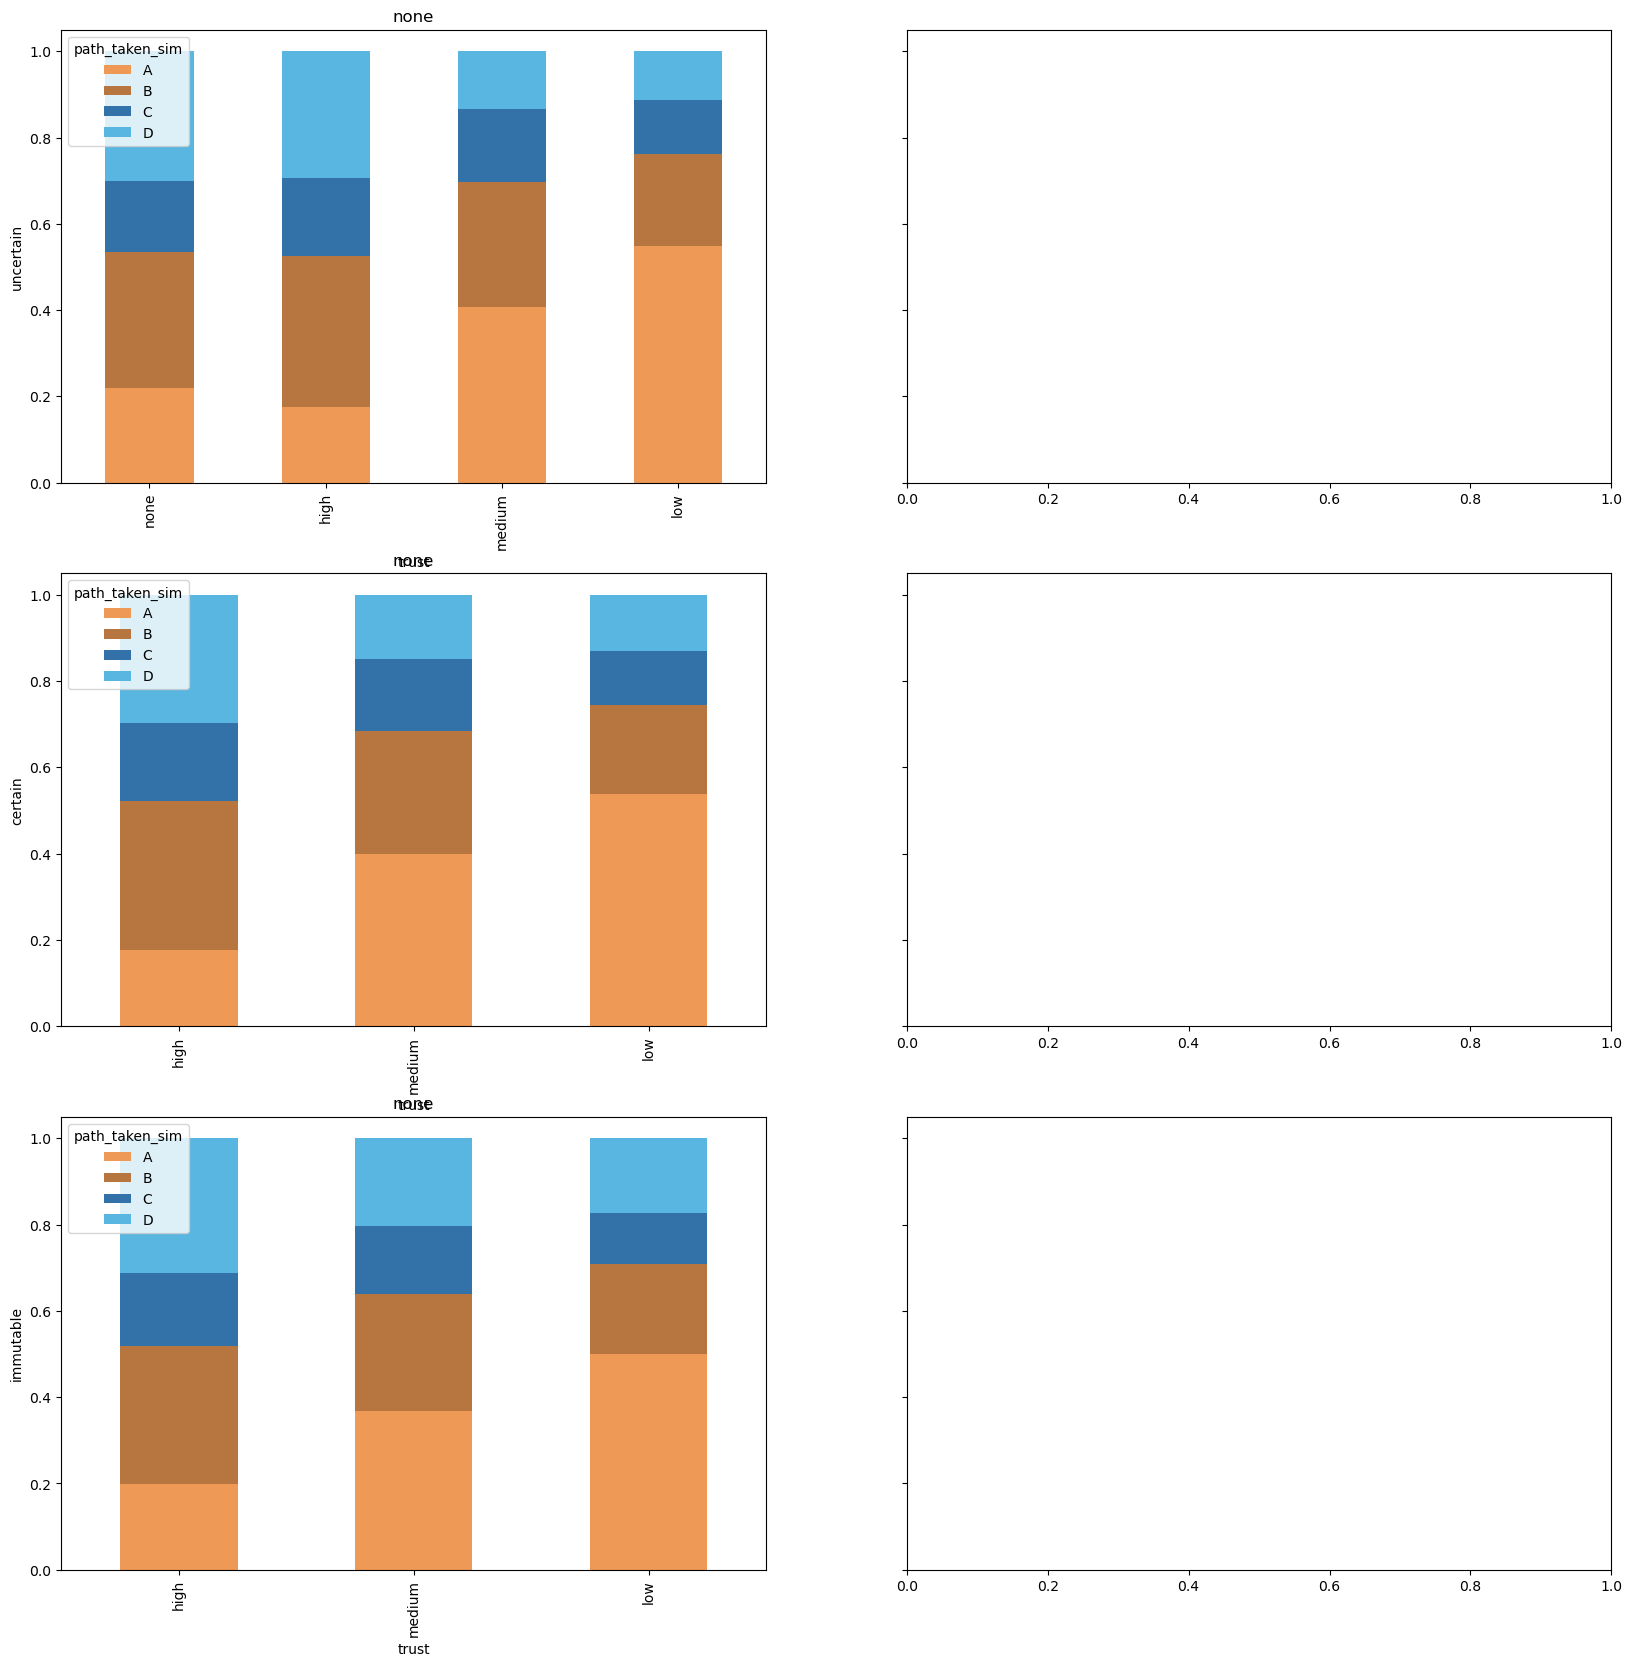

In [12]:
intentions = ['none', 'good']
interests = ['interested', 'disinterested']
#rigidities = np.sort(df.rigidity_val.dropna().unique())[::-1]
certainties = ['uncertain', 'certain', 'immutable']

trust_labels = [
    'none', 
    #'very_high', 
    'high', 
    #'slightly_high', 
    'medium', 
    #'slightly_low', 
    'low', 
    #'very_low'
]

fig, axes = plt.subplots(len(certainties), len(intentions), figsize=(20, 20), sharey=True)

for i, certainty in enumerate(certainties):
    for j, intention in enumerate(intentions):
        df_paths = df_Ys[(df_Ys.certainty == certainty)].groupby('trust').path_taken_sim.value_counts(normalize=True)
    
        
        if intention != 'none':
            continue
        # Reindex to only include trust_labels
        df_paths = df_paths.unstack().reindex(trust_labels).stack()
        # Set the order of trust labels to be as in trust_labels
        df_paths.unstack().plot(kind='bar', stacked=True, color=paths_colors, ax=axes[i, j])
        
        # Intention as y label only in the first column
        if j == 0:
            axes[i, j].set_ylabel(certainty)

        # Flexibility as title
        axes[i, j].set_title(intention)

## No beta

In [21]:
# Create list of participant data
part_data = []

# First drop all columns that are not y_sim
draws_y = draws.filter(like='y_nobeta_sim')
# Get the number of indices of M and N
M = stan_data['M']
N = stan_data['N']
# Iterate over the columns of draws_y

for col in draws_y.columns[:]:
    # Get the values of M and N from the column name
    mn = col.split('[')[1][:-1]
    m, n = mn.split(',')
    m = int(m)
    n = int(n)
    # Get the values of y_sim
    y_sim = draws_y[col].values

    
    # Create a new np array with the values of part_idx, block_idx and y_sim
    part_array = np.array([
        np.arange(y_sim.size),
        m*np.ones(y_sim.size), 
        n*np.ones(y_sim.size), 
        y_sim
    ]).T
    
    # Append to part_data
    part_data.append(part_array)

# Concatenate part_data
part_data_arr = np.concatenate(part_data)

In [47]:

# Add to draws_long
df_Ys = pd.DataFrame(part_data_arr.astype(int), columns=['sim_idx', 'part_idx', 'block_idx_local', 'y_sim'])

# Add certainty and trust to df_Ys_l
# Get the certainty and trust values for each block_idx
certainties = np.array(stan_data['certainties'])
trusts = np.array(stan_data['trusts'])

# Create new columns in df_Ys_l using the part_idx and block_idx columns as indices for certainties and trusts
df_Ys['certainty_lvl'] = certainties[df_Ys['part_idx'].values-1, df_Ys['block_idx_local'].values-1]
df_Ys['trust_lvl'] = trusts[df_Ys['part_idx'].values-1, df_Ys['block_idx_local'].values-1]

# Rename y_sim to path_idx_sim
df_Ys.columns = ['sim_idx', 'part_idx', 'block_idx_local', 'path_idx_sim', 'certainty_lvl', 'trust_lvl']

# Remap path_idx_sim to path_taken_sim using path_dict, same for certainty_lvl and trust_lvl
df_Ys['path_taken_sim'] = df_Ys['path_idx_sim'].map(lambda x: list(path_dict.keys())[list(path_dict.values()).index(x)])
df_Ys['certainty'] = df_Ys['certainty_lvl'].map(lambda x: list(certainties_dict.keys())[list(certainties_dict.values()).index(x)])
df_Ys['trust'] = df_Ys['trust_lvl'].map(lambda x: list(trust_dict.keys())[list(trust_dict.values()).index(x)])

df_Ys['part_idx'] = df_Ys['part_idx'] - 1
df_Ys['block_idx_local'] = df_Ys['block_idx_local'] - 1

# Recover participant code from pd.Categorical(df['participant_code']).codes
df_Ys['participant_code'] = pd.Categorical(df['participant_code']).categories[df_Ys['part_idx']-1]

df_Ys['block_idx'] = df_Ys['block_idx_local'] + 10

df_Ys = df_Ys[['sim_idx', 'part_idx', 'participant_code', 'block_idx_local', 'block_idx', 'certainty_lvl', 'trust_lvl', 'certainty', 'trust', 'path_idx_sim', 'path_taken_sim']]

# Save to csv
df_Ys.to_csv(f'stan_files/tom_model_{variant}_basic_y_nobeta_sim.csv', index=False)

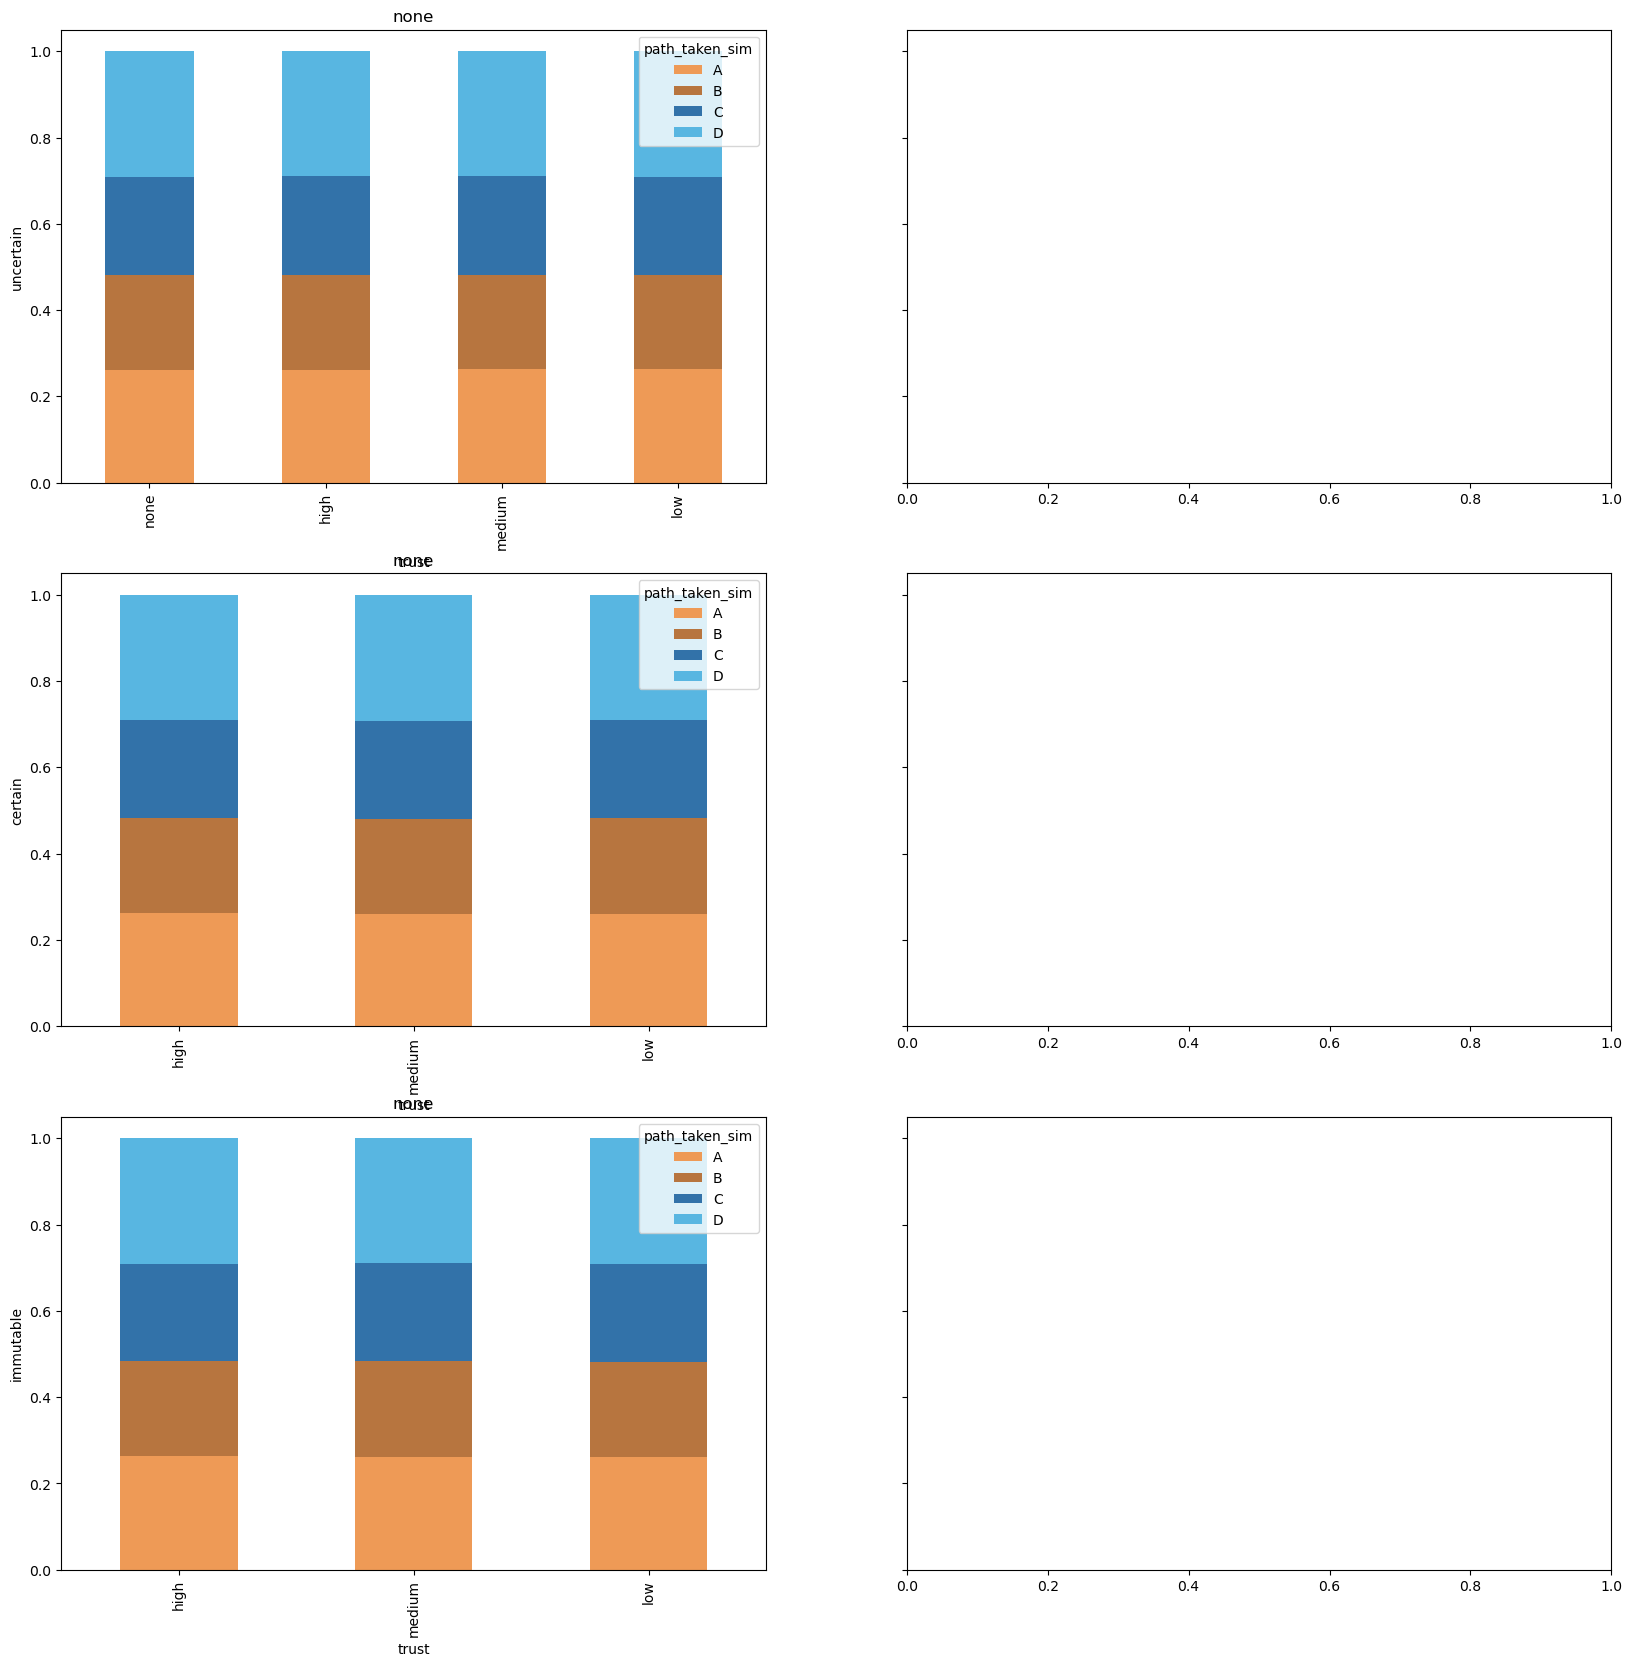

In [ ]:
intentions = ['none', 'good']
interests = ['interested', 'disinterested']
#rigidities = np.sort(df.rigidity_val.dropna().unique())[::-1]
certainties = ['uncertain', 'certain', 'immutable']

trust_labels = [
    'none', 
    #'very_high', 
    'high', 
    #'slightly_high', 
    'medium', 
    #'slightly_low', 
    'low', 
    #'very_low'
]

fig, axes = plt.subplots(len(certainties), len(intentions), figsize=(20, 20), sharey=True)

for i, certainty in enumerate(certainties):
    for j, intention in enumerate(intentions):
        df_paths = df_Ys[(df_Ys.certainty == certainty)].groupby('trust').path_taken_sim.value_counts(normalize=True)
    
        
        if intention != 'none':
            continue
        # Reindex to only include trust_labels
        df_paths = df_paths.unstack().reindex(trust_labels).stack()
        # Set the order of trust labels to be as in trust_labels
        df_paths.unstack().plot(kind='bar', stacked=True, color=paths_colors, ax=axes[i, j])
        
        # Intention as y label only in the first column
        if j == 0:
            axes[i, j].set_ylabel(certainty)

        # Flexibility as title
        axes[i, j].set_title(intention)